In [333]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

G = 6.674e-8

**Problem 1:** Compute formula for the overlap area of two circles as a function
of their separation, b, and radius ratio, $k=R_p/R_*$.

**Problem 2:** Write a function to compute the transit/secondary eclipse of a
body without limb-darkening.

In [48]:
def longAngle(t, t0, P):
    """
    True longitude angle as a function of time [rad]
    t  : time array [days]
    t0 : time of inferior conjunction [days]
    P  : period [days]
    """
    return 2*math.pi/P*(t - t0)


def skySep(theta, a, i):
    """
    Compute projected sky separation btwn planet and star
    theta  : true longitude [rad]
    a      : orbital radius [Rs]
    i      : inclination angle [rad]
    """
    d = a * np.sqrt(np.cos(theta)**2 + np.cos(i)**2 * np.sin(theta)**2)
    return d

In [275]:
def blockedArea(d, k):
    """
    Compute fraction of blocked area during ingress/egress
    d  : sky separation btwn planet and star [Rs]
    k  : radius ratio Rp/Rs
    """
    u = (d**2 + 1 - k**2)/(2*d)
    v = (d**2 + k**2 - 1)/(2*d*k)
    
    A1 = np.arccos(u) - u*np.sqrt(1 - u**2)
    A2 = k**2*np.arccos(v) - k**2*v*np.sqrt(1 - v**2)
    
    return A1 + A2


def transitFlux(tarr, k, a, i, t0, P, F0=1):
    """
    Compute transit light curve as a function of time and orbital parameters
    t  : time array [days]
    k  : radius ratio Rp/Rs
    a  : orbital radius [Rs]
    i  : inclination angle [rad]
    t0 : time of inferior conjunction [days]
    P  : period [days]
    """
    model_flux = []
    
    for t in tarr:
        theta = longAngle(t, t0, P)
        d = skySep(theta, a, i)

        # planet in front of star
        if 0 < theta < math.pi:
            if (d > 1 + k):
                model_flux.append(F0)
            elif (d >= 1 - k) & (d <= 1 + k):
                model_flux.append(F0*(1 - blockedArea(d,k)/math.pi))
            elif (d < 1 - k):
                model_flux.append(F0*(1 - k**2))
                
        # star in front of planet
        else:
            model_flux.append(F0)
    
    return np.array(model_flux)

In [274]:
a*np.cos(i), 1-k**2, min(model_flux)

(1.182450908671318, 0.9468922720525429, 0.9973285017877491)

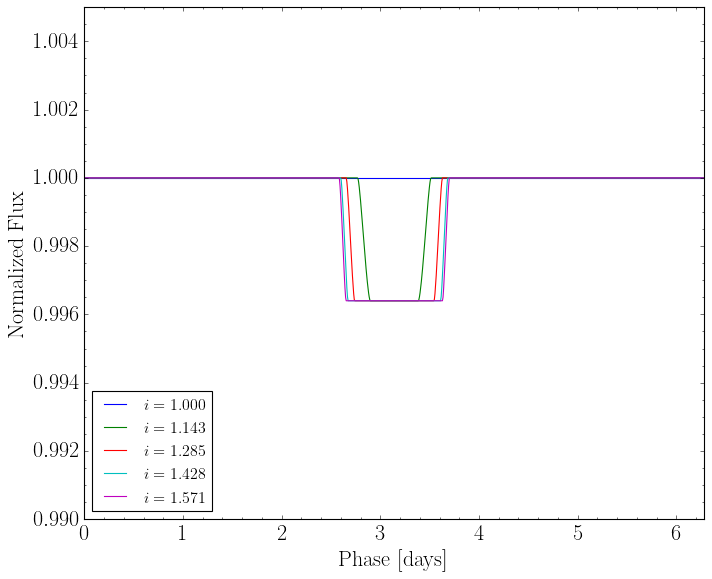

In [306]:
tarr = np.linspace(0, P, 1e3)

# k, a, i, t0, P = .05, .35, math.pi/3, 1, 2*math.pi

plt.figure(figsize=[10,8])
for i in np.linspace(1,math.pi/2,5):
    k = .06
    # i = 
    a = 2
    t0 = math.pi/2
    P = 2*math.pi
    model_flux = transitFlux(tarr, k, a, i, t0, P, F0=1)
    plt.plot(tarr, model_flux, label=r'$i=%.3f$'%(i))
# plt.plot(tarr, model_flux, color='r')
plt.ylim(0.99,1.005)
plt.xlim(0,P)
plt.legend(loc=3)
plt.xlabel('Phase [days]', fontsize=20)
plt.ylabel(r'Normalized Flux', fontsize=20)
plt.ticklabel_format(useOffset=False)
plt.minorticks_on()
plt.show()

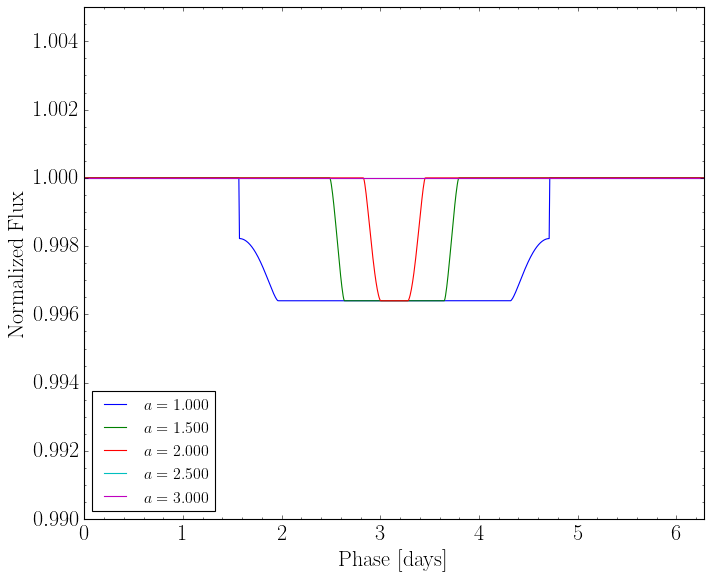

In [326]:
plt.figure(figsize=[10,8])
for a in np.linspace(1,3,5):
    k = .06
    i = 1.1
#     a = 2
    t0 = math.pi/2
    P = 2*math.pi
    model_flux = transitFlux(tarr, k, a, i, t0, P, F0=1)
    plt.plot(tarr, model_flux, label=r'$a=%.3f$'%(a))
# plt.plot(tarr, model_flux, color='r')
plt.ylim(0.99,1.005)
plt.xlim(0,P)
plt.legend(loc=3)
plt.xlabel('Phase [days]', fontsize=20)
plt.ylabel(r'Normalized Flux', fontsize=20)
plt.ticklabel_format(useOffset=False)
plt.minorticks_on()
plt.show()

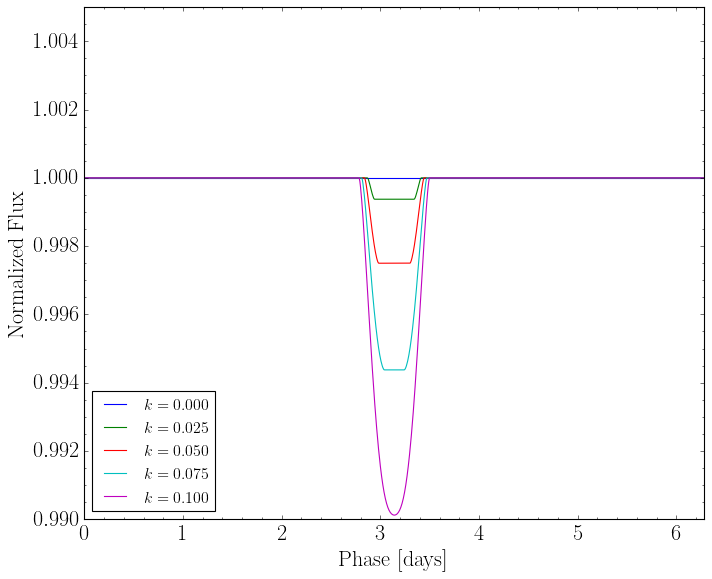

In [308]:
plt.figure(figsize=[10,8])
for k in np.linspace(0,.1,5):
    i = 1.1
    a = 2
    t0 = math.pi/2
    P = 2*math.pi
    model_flux = transitFlux(tarr, k, a, i, t0, P, F0=1)
    plt.plot(tarr, model_flux, label=r'$k=%.3f$'%(k))
# plt.plot(tarr, model_flux, color='r')
plt.ylim(0.99,1.005)
plt.xlim(0,P)
plt.legend(loc=3)
plt.xlabel('Phase [days]', fontsize=20)
plt.ylabel(r'Normalized Flux', fontsize=20)
plt.ticklabel_format(useOffset=False)
plt.minorticks_on()
plt.show()

**Problem 3:** Use your model to fit the data ‘mystery_planet02.txt’. What is the
period? What is the depth, impact parameter, and duration of this
transiting body? What is the density of the star?

In [117]:
data = pd.read_csv('files/mystery_planet02.txt', delim_whitespace=True, header=None)

time, flux, flux_err = np.array(data[0]), np.array(data[1]), np.array(data[2])

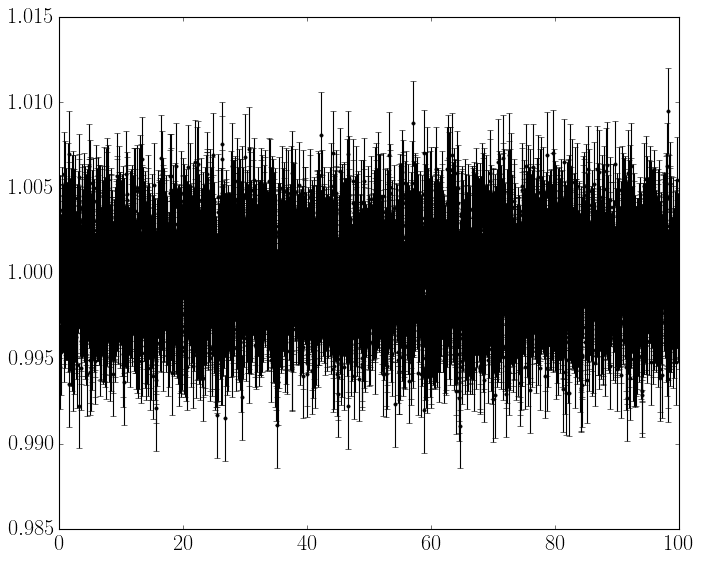

In [9]:
plt.figure(figsize=[10,8])
plt.errorbar(time, flux, yerr=flux_err, fmt='.', color='k')
plt.ticklabel_format(useOffset=False)
plt.show()

In [122]:
def phase_fold(time, flux, flux_err, P):
    
    fold = time % P
    phase_sort = np.argsort(fold)

    phase_time = fold[phase_sort]
    phase_flux = flux[phase_sort]
    phase_flux_err = flux_err[phase_sort]
    
    return phase_time, phase_flux, phase_flux_err

In [10]:
from astropy.timeseries import BoxLeastSquares
import astropy.units as u

In [119]:
model = BoxLeastSquares(time * u.day, flux, dy=flux_err)

periods = np.linspace(1, 50, 1e5) * u.day
periodogram = model.power(periods, 0.2)

best period: 9.793627936279362 d


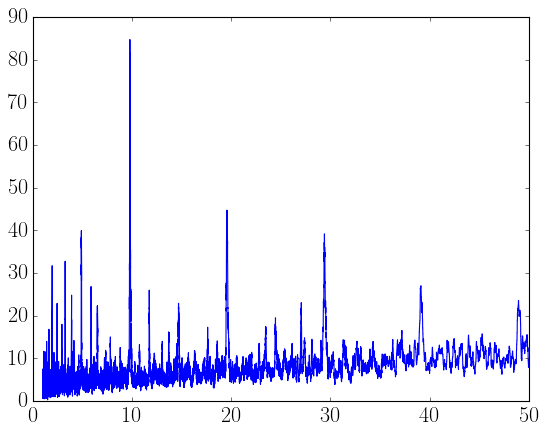

In [120]:
plt.plot(periodogram.period, periodogram.power);
print('best period:', periodogram.period[np.argmax(periodogram.power)])

In [336]:
def plot_lc_model(theta, data, P, **kwargs):
    """
    Plot light curve with parameters theta, compute chi^2
    and calculate other parameters of interest (b, delta, T, tau, rho)
    
    theta  : array of transit model parameters (k, a, i, t0)
    data   : phase folded data arrays (phase_time, phase_flux, phase_flux_err)
    P      : best fit period (using BLS)
    """
    k, a, i, t0 = theta
    phase_time, phase_flux, phase_flux_err = data
    
    # compute flux over one period to plot
    tarr = np.linspace(0, P, 1e3)
    plot_model_flux = transitFlux(tarr, k, a, i, t0, P, F0=1)
    
    # compute chi^2 of model with parameters given in theta
    model_flux = transitFlux(phase_time, k, a, i, t0, P, F0=1)
    chi_val = np.sum(((phase_flux - model_flux)/phase_flux_err)**2)
    
    # calculate other parameters of interest
    b     = a*np.cos(i)
    delta = k**2 
    T     = np.sqrt(1 - b**2)/(math.pi*a)*P
    tau   = k*T/(1 - b**2)
    rho   = 3/math.pi**2 * P/(G*T**3) * (1 - b**2)**(3/2)
    
    lbl = r'Model fit: $k=%.3f, a=%.3f, i=%.3f, t_0=%.3f, P=%.3f$'%(k, a, i, t0, P)
    lbl2 = r'$b=%.3f, \delta=%.4f, T=%.3f, \tau=%.3f, \rho=%.3f$'%(b, delta, T, tau, rho)
    
    # plot data and model
    plt.figure(figsize=[20,8])
    plt.errorbar(phase_time, phase_flux, yerr=phase_flux_err, fmt='.', color='k', elinewidth=.3)
    plt.plot(tarr, plot_model_flux, color='r', linewidth=2, label=r'$\chi^2=%.3f$'%(chi_val))
    plt.text(.15, 1.013, lbl, ha='left', fontsize=18)
    plt.text(.15, .987, lbl2, ha='left', va='top', fontsize=18)
    plt.xlim(0, P)
    plt.title('Transit Model Fit', fontsize=22)
    plt.xlabel('Phase [days]', fontsize=20)
    plt.ylabel(r'Normalized Flux', fontsize=20)
    plt.legend(loc='lower right')
    plt.ticklabel_format(useOffset=False)
    plt.minorticks_on()
    if 'save' in kwargs:
        plt.savefig(kwargs.get('save'))
    plt.show()
    
    return b, delta, T, tau, rho

In [284]:
theta = longAngle(tarr, t0, P)
d = skySep(theta, a, i)
min(d), max(d), 1+k, 1-k

(0.5350050565864306, 1.9999999882965689, 1.07, 0.9299999999999999)

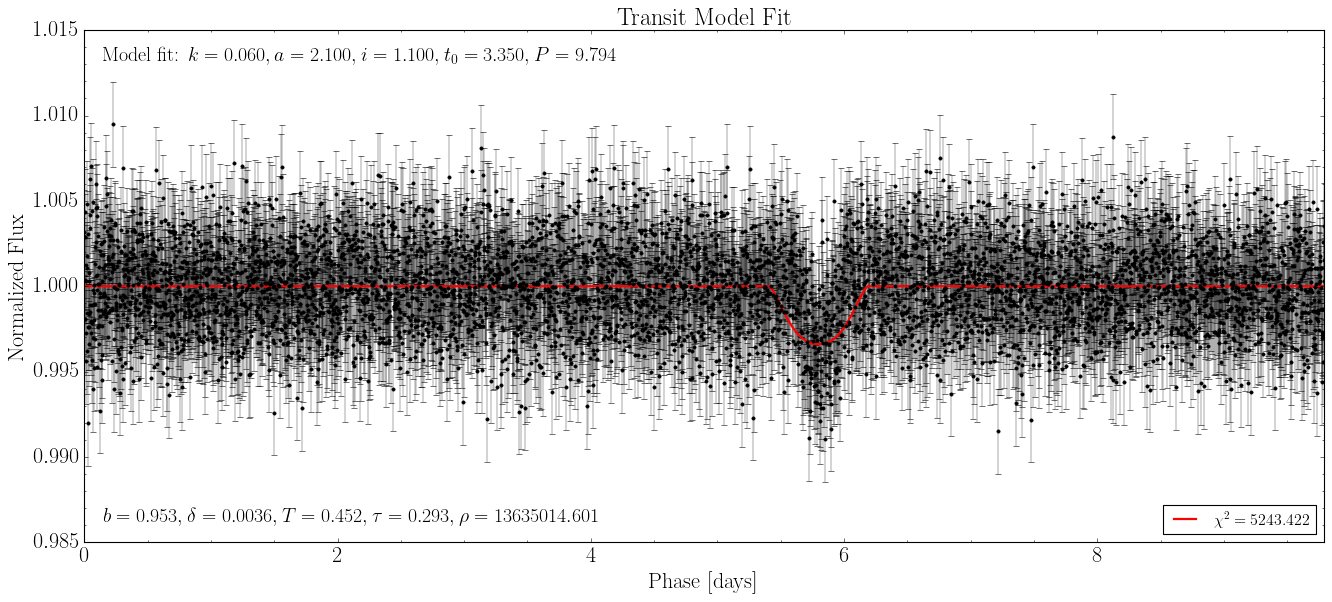

(0.9525518549937124,
 0.0036,
 0.45184069280661354,
 0.29262725711300813,
 13635014.600891817)

In [337]:
k = .06
i = 1.1
a = 2.1
t0 = 3.35
P = best_period

theta = [k, a, i, t0]
data = phase_time, phase_flux, phase_flux_err

plot_lc_model(theta, data, P, save='transit_model_initial.png')

In [230]:
def log_likelihood(theta, data, P):
    """
    Assume Gaussian likelihood function
    theta : model parameters (k, a, i, t0, P)
    data  : phase-folded time, flux, flux_err
    P     : period, fixed during optimization
    """
    k, a, i, t0 = theta
    phase_time, phase_flux, phase_flux_err = data
    
    phase_flux_model = transitFlux(phase_time, k, a, i, t0, P)
    
    return -0.5 * np.sum((phase_flux - phase_flux_model)**2/phase_flux_err**2)

nll = lambda *args: -log_likelihood(*args)

In [321]:
initial = [k, a, i, t0]
bounds  = [(0,1), (1,5), (0,math.pi/2), (0,P)]
data    = [phase_time, phase_flux, phase_flux_err]

soln = minimize(nll, initial, method='TNC', bounds=bounds, args=(data, P))

In [322]:
print(soln)
print('initial:', initial)

     fun: 2563.0111097221284
     jac: array([ 54.61270121, -37.09387784,  97.97226994, 161.7588623 ])
 message: 'Max. number of function evaluations reached'
    nfev: 100
     nit: 17
  status: 3
 success: False
       x: array([0.51925246, 2.70467702, 0.99335838, 3.37724205])
initial: [0.06, 2.1, 1.1, 3.35]


/home/jbirky/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
/home/jbirky/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


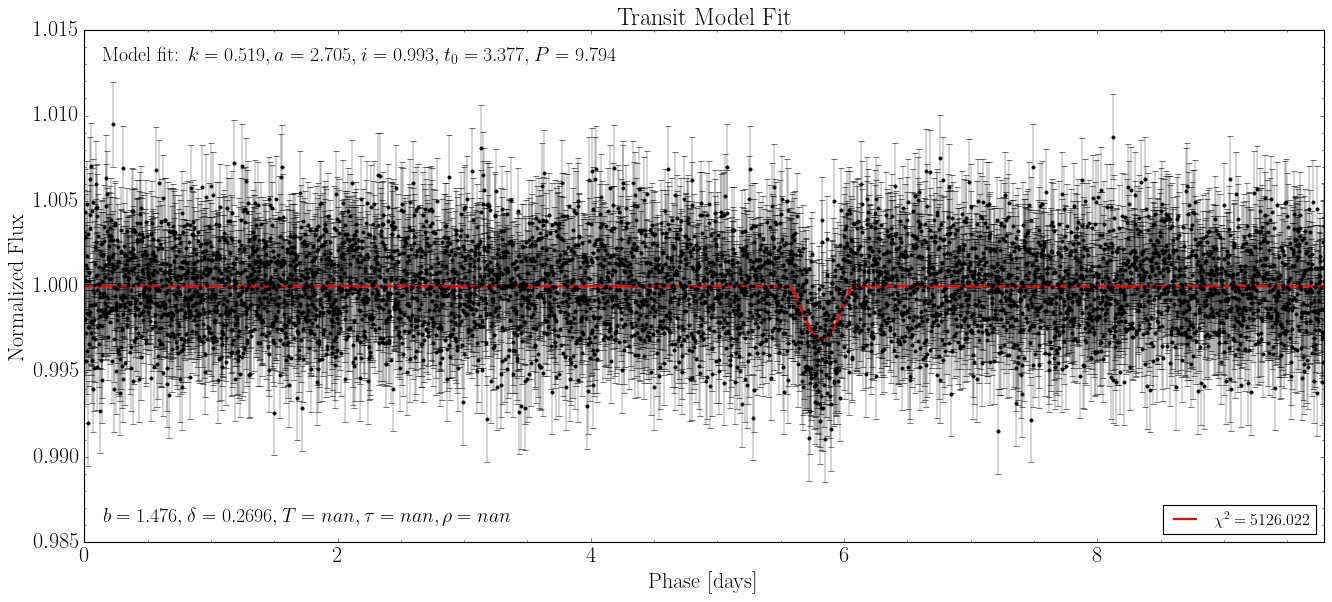

(1.4764265927781515, 0.2696231128087249, nan, nan, nan)

In [338]:
k_sol, a_sol, i_sol, t0_sol = soln.x
plot_lc_model(soln.x, data, best_period, save='transit_model_final.png')

In [330]:
initial = []
bounds  = [(0,1), (1,5), (0,math.pi/2), (0,P)]

def log_prior(theta):
    k, a, i, t0 = theta
    if (bounds[0][0] < k < bounds[0][1]) & (bounds[1][0] < a < bounds[1][1]) \
        & (bounds[2][0] < i < bounds[2][1]) & (bounds[3][0] < t0 < bounds[3][1]):
        return 0.0
    return -np.inf

def log_probability(theta, data, P):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, data, P)

In [332]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(data, P))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [1:48:57<00:00,  1.31s/it]


In [334]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [ ]:
import corner

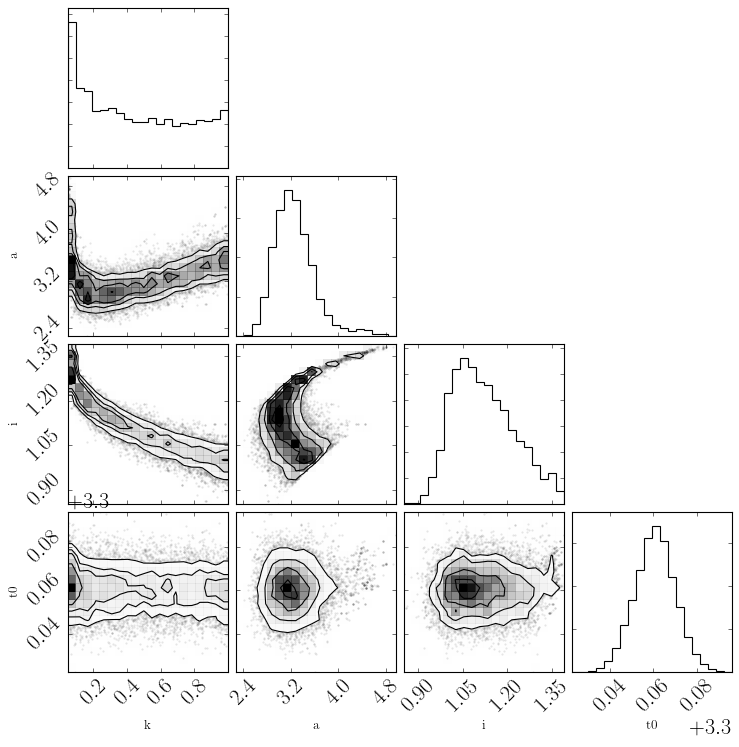

In [345]:
fig = corner.corner(flat_samples, labels=['k', 'a', 'i', 't0']);
fig.savefig('posterior.png')

**Extra Credit:** find the probability distribution of parameters
assuming a circular orbit

In [191]:
1-k_sol**2

0.9468922720525429

In [206]:
flux_err

array([0.0025, 0.0025, 0.0025, ..., 0.0025, 0.0025, 0.0025])

In [ ]:
1-k_sol**2=0.9468